In [1]:
import os
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from PIL import Image

from prediction_utils import predict_proba
from shufflenet import get_shufflenet

In [2]:
# this file is created after training is finished
config_path = 'logs/run0/model_config.txt'

# folder where validation dataset is
validation_images = 'tiny-imagenet-200/validation/'

# this file is created when you run `image_dataset_to_tfrecords.py`
class_encoder_path = 'tiny-imagenet-200/class_encoder.npy'

# this file comes with dataset
class_names_file = 'tiny-imagenet-200/words.txt'

In [3]:
# folder name -> class name in human readable format
class_names = pd.read_csv(class_names_file, sep='\t', header=None)
names = dict(class_names.set_index(0)[1])

# folder name -> class index
encoder = np.load(class_encoder_path)[()]

# class index -> class name in human readable format
decoder = {encoder[i]: names[i] for i in encoder}

In [4]:
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
config = json.load(open(config_path))

In [6]:
graph, ops = get_shufflenet(
    groups=config['groups'], 
    complexity_scale_factor=config['complexity_scale_factor']
)

In [7]:
filenames = ['n02056570/val_1073.JPEG', 'n02106662/val_3641.JPEG', 'n01774384/val_1684.JPEG']
images = [Image.open(validation_images + name) for name in filenames]

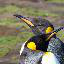

In [8]:
images[0]

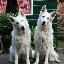

In [9]:
images[1]

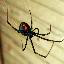

In [10]:
images[2]

In [11]:
images = [image.resize((56, 56)) for image in images]
X = [np.asarray(image).astype('float32') for image in images]
X = np.stack(X)  # batch
X /= 255.0  # normalize to [0, 1] range

In [12]:
predictions = predict_proba(graph, ops, X, run=config['run'])

In [13]:
print([decoder[i] for i in predictions.argmax(1)])

['king penguin, Aptenodytes patagonica', 'fur coat', 'black widow, Latrodectus mactans']


In [14]:
def _order_by_number_in_name(image_filename):
    return int(image_filename[4:-5])

In [15]:
## Validation data set predictions:

In [16]:
f = np.genfromtxt('tiny-imagenet-200/val_annotations.txt',dtype='str')
images_ = [
    image_filename
    for image_filename in os.listdir('tiny-imagenet-200/val/images/')
    if not image_filename.startswith('.')
]
images_ = sorted(images_, key=_order_by_number_in_name)
class_names_by_image_number = {array[0]: array[1] for array in f}

In [ ]:
# get the images and format them

In [17]:
array_image_list = []
kept_val_image_filenames = []
for image_filename in images_:
    opened_image = Image.open('tiny-imagenet-200/val/images/' + image_filename)
    resized_image = opened_image.resize((56, 56))
    standardized_array = np.asarray(resized_image).astype('float32')
    if standardized_array.shape == (56, 56, 3):
        kept_val_image_filenames.append(image_filename)
        array_image_list.append(standardized_array)
X_val = np.stack(array_image_list)
X_val /= 255.

In [18]:
np.savez('kept_val_images', np.asanyarray(kept_val_image_filenames))

In [19]:
np.savez('x_val', np.asanyarray(X_val))

In [ ]:
# perform predictions

In [29]:
predictions_validation = predict_proba(graph, ops, X_val, run=config['run'])
predictions_argmax = np.argmax(predictions_validation, 1)

In [30]:
np.savez('teacher_logits_val', np.asanyarray(predictions_validation))

In [31]:
# getting labels category numbers , ex: n02056570

labels_number_list = [class_names_by_image_number[kept_filename] for kept_filename in kept_val_image_filenames]

# translating the label category number into the corresponding index

labels_idx_list = [encoder[label_nb] for label_nb in labels_number_list]

labels_idx_list = np.array(labels_idx_list)

# computing prediction accuracy

np.mean((labels_idx_list == predictions_argmax))

0.5072213181448332

In [32]:
np.savez('y_val', np.asanyarray(labels_idx_list))

In [ ]:
#Training dataset predictions

In [19]:
images_folders = [
    image_folder
    for image_folder in os.listdir('tiny-imagenet-200/training/')
    if not image_folder.startswith('.')
]

In [20]:
array_image_dict = {}
array_image_list = []
kept_image_filenames = []
for image_folder in images_folders:
    images_list = [ image_filename for image_filename in os.listdir('tiny-imagenet-200/training/' + image_folder)
               if not image_filename.startswith('.')]
#     images_list = sorted(images_list, key=_order_by_number_in_name)
    for image_filename in images_list:
        opened_image = Image.open('tiny-imagenet-200/training/' + image_folder +'/'+ image_filename)
        resized_image = opened_image.resize((56, 56))
        standardized_array = np.asarray(resized_image).astype('float32')
        
        if standardized_array.shape == (56, 56, 3):
            kept_image_filenames.append(image_filename)
            array_image_dict[image_filename] = standardized_array
            array_image_list.append(standardized_array)
X_train = np.stack(array_image_list)
X_train /= 255.

In [21]:
np.savez('x_train', np.asanyarray(X_train))

In [11]:
batch_size = 1000

In [14]:
# predictions_training = [predict_proba(graph, ops, X[i], run=config['run']) for i in ]
predictions_training = []
for batch_idx in range(X.shape[0] // batch_size + 1):
    print("new batch")
    X_batch = X[batch_idx * batch_size: (batch_idx + 1) * batch_size]
    batch_pred = predict_proba(graph, ops, X_batch, run=config['run'])
    predictions_training.append(batch_pred)
predictions_training = np.stack(predictions_training)


new batch
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from saved/run0/model
new batch
INFO:tensorflow:Restoring parameters from saved/run0/model
new batch
INFO:tensorflow:Restoring parameters from saved/run0/model
new batch
INFO:tensorflow:Restoring parameters from saved/run0/model
new batch
INFO:tensorflow:Restoring parameters from saved/run0/model
new batch
INFO:tensorflow:Restoring parameters from saved/run0/model
new batch
INFO:tensorflow:Restoring parameters from saved/run0/model
new batch
INFO:tensorflow:Restoring parameters from saved/run0/model
new batch
INFO:tensorflow:Restoring parameters from saved/run0/model
new batch
INFO:tensorflow:Restoring parameters from saved/run0/model
new batch
INFO:tensorflow:Restoring parameters from saved/run0/model
new batch
INFO:tensorflow:Restoring parameters from saved/run0/model
new batch
INFO:tensorflow:Restoring parameters from saved/run0/model
new batch
INFO:t

In [61]:
predictions_training = predictions_training.reshape((98000, 200))

In [67]:
X_batch = X[98000:]
batch_pred = predict_proba(graph, ops, X_batch, run=config['run'])

INFO:tensorflow:Restoring parameters from saved/run0/model


In [71]:
predictions_training = np.concatenate((predictions_training, batch_pred), axis=0)

In [77]:
# getting labels category numbers , ex: n02056570

labels_number_list = [kept_filename.split('_')[0] for kept_filename in kept_image_filenames]

In [79]:
# translating the label category number into the corresponding index

labels_idx_list = [encoder[label_nb] for label_nb in labels_number_list]

In [80]:
labels_idx_list = np.array(labels_idx_list)

In [81]:
predictions_argmax = np.ndarray.flatten(np.argmax(predictions_training,axis=1))

In [82]:
# computing prediction accuracy

np.mean((labels_idx_list == predictions_argmax))

0.598620886340256

In [ ]:
#save logits in a file:

In [85]:
np.savez('/home/mherrera/CNN-using-tensor-flow-tiny-imageNet/teacher_logits_train', predictions_training)

In [ ]:
#load them again

In [95]:
test_predictions_training = np.load(
    '/home/mherrera/CNN-using-tensor-flow-tiny-imageNet/teacher_logits_train.npz'
)['arr_0']

In [96]:
test_predictions_argmax = np.ndarray.flatten(np.argmax(test_predictions_training, axis=1))

In [97]:
np.mean((labels_idx_list == test_predictions_argmax))

0.598620886340256